## Score Model w/ Weather EDA

### Objective

* Evaluation of basic linear model using weather factors and previous scores

### Rationale

*  Why This?  Before establishing a baseline model, the performance implications of various model choices need to be explored.

*  Why Me?  Because I will be building the baseline model, I am the logical choice

*  Why Now?  Data from a reproducible pipeline is now available; understanding model choices is necessary before continuing on the project critical path of model implementation

### Requirements

*  Pandas 0.24.2
*  Scikit-learn 0.21.2
*  Matplotlib 3.1.0

### Input / Output

*  This notebook is expected to be in `models/notebooks/eda`

*  The input weather data is in a file `models/wx_model_data/wx_model.csv`

*  The input score data is in a file `models/score_model_data/scores.csv`

*  The output models are stored in a file `models/score_model_data/linear_model_fits.csv`

### Import / Set-Up

In [75]:
import pandas as pd
import sklearn as sk
import numpy as np
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Get weather data
wx_df = pd.read_csv('../../wx_model_data/wx_model.csv', parse_dates = ['date'])
# Get scores data
scores_df = pd.read_csv('../../score_model_data/scores.csv', parse_dates = ['time'])

In [3]:
wx_df.head()

,Unnamed: 0,date,w_spd,precip,weighted_T,weighted_w_dir,weighted_w_spd,weighted_w_gust,weighted_rh,weighted_precip,weighted_w_u,weighted_w_v,course_id
0,0,2018-11-18,6.863194,0.005417,51.130278,72.556944,3.365000,7.305000,93.317917,0.000000,2.201613,1.558933,0
1,1,2019-03-11,0.302778,0.002167,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
2,2,2018-11-04,13.681944,0.001056,57.929792,231.829722,2.637569,5.607500,82.701042,0.000817,-2.128643,-1.196988,0
3,3,2019-03-17,5.604167,0.000000,68.041667,215.895833,0.980324,1.526620,48.973380,0.000000,-0.654349,-0.149641,1
4,4,2018-12-02,6.694444,0.000000,51.899537,74.433333,1.561806,5.042824,66.128935,0.000000,0.997931,0.962995,0


In [4]:
scores_df.head()

,Unnamed: 0,Name,Raw,Handicap,Adjusted,time,course_id
0,0,Mark Shannon,61.0,-12.40,48.60,2019-01-19 08:00:00,1
1,1,Jacob Kermish-Wells,60.0,-10.72,49.28,2019-01-19 08:00:00,1
2,2,Luiz Celeste,55.0,-5.23,49.77,2019-01-19 08:00:00,1
3,3,Tu Tran,59.0,-9.07,49.93,2019-01-19 08:00:00,1
4,4,Matty Angell,53.0,-1.50,51.50,2019-01-19 08:00:00,1


In [4]:
# Clean out duplicated indexes
wx_df = wx_df.drop(columns = 'Unnamed: 0')
scores_df = scores_df.drop(columns = 'Unnamed: 0')

In [5]:
# Sort prior to merge
wx_df = wx_df.sort_values(by = ['date','course_id'])
scores_df = scores_df.sort_values(by= ['time','course_id','Name'])

In [6]:
all_df = pd.merge_asof(scores_df, wx_df, by = 'course_id', left_on= 'time', right_on = 'date',
                       direction = 'backward', tolerance = pd.Timedelta('1d') )
all_df.head()

,Name,Raw,Handicap,Adjusted,time,course_id,date,w_spd,precip,weighted_T,weighted_w_dir,weighted_w_spd,weighted_w_gust,weighted_rh,weighted_precip,weighted_w_u,weighted_w_v
0,Alex Torres,68.0,NaN,NaN,2012-11-18 07:30:00,0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Andy Leaf,53.0,NaN,NaN,2012-11-18 07:30:00,0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Anthony McGinnis,78.0,NaN,NaN,2012-11-18 07:30:00,0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Aurelius Lewicki,57.0,NaN,NaN,2012-11-18 07:30:00,0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Billy Manger,58.0,NaN,NaN,2012-11-18 07:30:00,0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# Drop any rows that do not have weather data
all_df = all_df.dropna(subset = ['w_spd'])
all_df.head()

,Name,Raw,Handicap,Adjusted,time,course_id,date,w_spd,precip,weighted_T,weighted_w_dir,weighted_w_spd,weighted_w_gust,weighted_rh,weighted_precip,weighted_w_u,weighted_w_v
521,Anni Kreml,57.0,NaN,NaN,2017-03-15 09:00:00,2,2017-03-15,13.402778,0.0,57.358333,154.450694,2.480556,0.0,79.685417,0.0,0.169702,-1.088677
522,Bob Montes,61.0,NaN,NaN,2017-03-15 09:00:00,2,2017-03-15,13.402778,0.0,57.358333,154.450694,2.480556,0.0,79.685417,0.0,0.169702,-1.088677
523,Case Conover,56.0,NaN,NaN,2017-03-15 09:00:00,2,2017-03-15,13.402778,0.0,57.358333,154.450694,2.480556,0.0,79.685417,0.0,0.169702,-1.088677
524,Conner Russell,69.0,NaN,NaN,2017-03-15 09:00:00,2,2017-03-15,13.402778,0.0,57.358333,154.450694,2.480556,0.0,79.685417,0.0,0.169702,-1.088677
525,David Falzone,58.0,NaN,NaN,2017-03-15 09:00:00,2,2017-03-15,13.402778,0.0,57.358333,154.450694,2.480556,0.0,79.685417,0.0,0.169702,-1.088677


In [8]:
len(all_df)

2945

In [77]:
def model_player_performance(player : str, course : int):
    """Given a player name and course id, return model parameters indicating the effects of weather on expected score.
    The model will return a dictionary with coefficients for easy identification"""
    
    model_dict = {}
    player_df = all_df[(all_df['Name'] == player) & (all_df['course_id'] == course)]
    # Replace index with the cumulative number of games played, and make that into a column
    player_df = player_df.reset_index()
    player_df = player_df.drop(columns = ['index'])
    player_df = player_df.reset_index()
    
    #Build weather model
    X = player_df[['index','weighted_w_gust','weighted_precip']].values
    y = player_df['Raw'].values
    
    if len(player_df) > 2:
        scaler = StandardScaler()
        lr = ElasticNetCV(l1_ratio = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99], cv = 3, random_state=42)
        pipeline = make_pipeline(scaler, lr)
        pipeline.fit(X,y)
        cumgame_coeff, wind_coeff, precip_coeff = pipeline['elasticnetcv'].coef_
        model_dict['prediction_score'] = pipeline.score(X,y)
        model_dict['cumgame_coeff'] = cumgame_coeff
        model_dict['wind_coeff'] = wind_coeff
        model_dict['precip_coeff'] = precip_coeff
        model_dict['intercept'] = pipeline['elasticnetcv'].intercept_
    elif len(player_df) > 0:
        model_dict['intercept'] = np.mean(y)
    else:
        model_dict['nomatch'] = 1
        
    return model_dict    

In [78]:
#Make list of player names
player_names = all_df['Name'].unique()
model_scores, game_coeffs, wind_coeffs, precip_coeffs, intercepts = ([] for _ in range(5))
for player_name in player_names:
    for course_id in range(all_df['course_id'].max() + 1):
        perf_dict = model_player_performance(player_name, course_id)
        model_score = perf_dict.get('prediction_score',None)
        if model_score is not None:
            model_scores.append(model_score)
        game_coeff = perf_dict.get('cumgame_coeff',None)
        if game_coeff is not None:
            game_coeffs.append(game_coeff)
        wind_coeff = perf_dict.get('wind_coeff',None)
        if wind_coeff is not None:
            wind_coeffs.append(wind_coeff)
        precip_coeff = perf_dict.get('precip_coeff',None)
        if precip_coeff is not None:
            precip_coeffs.append(precip_coeff)
        intercept = perf_dict.get('intercepte',None)
        if model_score is not None:
            intercepts.append(intercept)

C:\Users\andre\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\l

C:\Users\andre\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\l

C:\Users\andre\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.013271458051939078, tolerance: 0.010066666666666668
  positive)
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.016687594738208134, tolerance: 0.010066666666666668
  positive)
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02076174008471554, tolerance: 0.010066666666666668
  positive)
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iteratio

C:\Users\andre\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  positive)
C:\Users\andre\Anaconda3\lib\site-packages\sklearn\l

(array([109.,   4.,   7.,   4.,   2.,   5.,   5.,  10.,   5.,   3.,   4.,
          4.,   4.,   3.,   3.,   2.,   1.,   1.,   2.,   1.,   1.,   1.,
          2.,   1.,   3.,   2.,   2.,   1.,   3.,   2.,   3.,   2.,   1.,
          0.,   4.,   2.,   7.,   3.,   2.,   2.,   2.,   3.,   0.,   1.,
          4.,   5.,   1.,   3.,   0.,  26.]),
 array([0.        , 0.01999995, 0.0399999 , 0.05999985, 0.0799998 ,
        0.09999975, 0.1199997 , 0.13999964, 0.15999959, 0.17999954,
        0.19999949, 0.21999944, 0.23999939, 0.25999934, 0.27999929,
        0.29999924, 0.31999919, 0.33999914, 0.35999909, 0.37999904,
        0.39999898, 0.41999893, 0.43999888, 0.45999883, 0.47999878,
        0.49999873, 0.51999868, 0.53999863, 0.55999858, 0.57999853,
        0.59999848, 0.61999843, 0.63999838, 0.65999832, 0.67999827,
        0.69999822, 0.71999817, 0.73999812, 0.75999807, 0.77999802,
        0.79999797, 0.81999792, 0.83999787, 0.85999782, 0.87999777,
        0.89999772, 0.91999766, 0.93999761, 0.

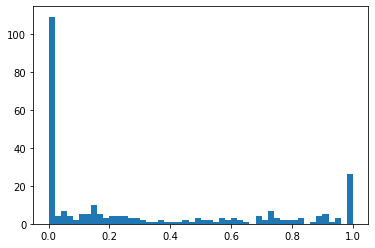

In [87]:
plt.hist(model_scores, bins=50)